In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/efficientnet_3channel_scratch.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/val'
TEST_IMAGE_FOLDER = '/home/TBX11K/test'
SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

### EfficientNet Model

In [3]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable=False

hidden = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
batch_norm = tf.keras.layers.Dropout(0.5)(hidden)
y = tf.keras.layers.Dense(3, activation="softmax", kernel_initializer="he_normal")(batch_norm)
eff_model = tf.keras.Model(inputs=base_model.input, outputs=y)
    
eff_model.summary()

2022-08-26 17:39:56.482038: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-26 17:39:56.482117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

#### Keras Callbacks

In [4]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(eff_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(eff_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.3,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 7566 images belonging to 3 classes.
Found 1551 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.7479240806642942, 1: 0.8135483870967742, 2: 2.3053016453382082}
samples for train class labels: dict_items([(0, 3372), (1, 3100), (2, 1094)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 702), (1, 600), (2, 249)])


#### EfficientNet Compilation and Execution

In [6]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
eff_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [7]:
warnings.filterwarnings("ignore")
epochs = 15
history = eff_model.fit(train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=validation_generator, 
                                epochs=epochs,
                                verbose = 1,
                                class_weight = class_weights,
                                callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  0.001
Epoch 1/15


2022-08-26 17:40:12.269656: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


237/237 [==============================] - ETA: 0s - loss: 0.7642 - accuracy: 0.6807 - AUC: 0.8546 - precision: 0.7429 - recall: 0.5892
Epoch 00001: val_loss improved from inf to 0.47406, saving model to ./weights/efficientnet_3channel_scratch.hdf5
End of epoch 0. Learning rate: 0.001
237/237 [==============================] - 107s 424ms/step - loss: 0.7642 - accuracy: 0.6807 - AUC: 0.8546 - precision: 0.7429 - recall: 0.5892 - val_loss: 0.4741 - val_accuracy: 0.8259 - val_AUC: 0.9500 - val_precision: 0.8730 - val_recall: 0.7666 - lr: 0.0010
Learning rate:  0.001
Epoch 2/15
237/237 [==============================] - ETA: 0s - loss: 0.5730 - accuracy: 0.7883 - AUC: 0.9246 - precision: 0.8263 - recall: 0.7425
Epoch 00002: val_loss did not improve from 0.47406
End of epoch 1. Learning rate: 0.001
237/237 [==============================] - 104s 438ms/step - loss: 0.5730 - accuracy: 0.7883 - AUC: 0.9246 - precision: 0.8263 - recall: 0.7425 - val_loss: 0.5039 - val_accuracy: 0.8021 - val_AUC

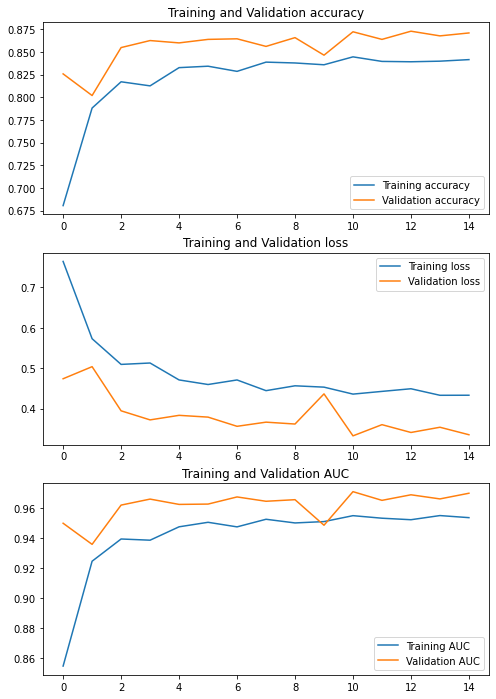

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

In [9]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
10,0.436057,0.844700,0.955046,0.862112,0.825535,0.332819,0.872340,0.971073,0.891143,0.849774,0.001
14,0.433273,0.841660,0.953724,0.858772,0.826196,0.335561,0.871051,0.970020,0.889413,0.850419,0.001
12,0.449304,0.839281,0.952337,0.857499,0.818398,0.341173,0.872985,0.968985,0.890836,0.852353,0.001
13,0.433134,0.839942,0.955111,0.857380,0.820777,0.354093,0.867827,0.966233,0.880697,0.847195,0.001
6,0.471055,0.828707,0.947563,0.851249,0.801745,0.356414,0.864603,0.967549,0.884303,0.842682,0.001
11,0.442766,0.839678,0.953349,0.859067,0.817737,0.360476,0.863959,0.965271,0.880968,0.844616,0.001
8,0.456593,0.837959,0.950188,0.857481,0.814301,0.362049,0.865893,0.965718,0.884303,0.842682,0.001
7,0.444609,0.838884,0.952644,0.861446,0.812715,0.366688,0.856222,0.964657,0.874832,0.838169,0.001
3,0.512967,0.812715,0.938669,0.841594,0.778747,0.372293,0.862669,0.966114,0.899367,0.823985,0.001


#### EfficientNet Fine tuning

In [12]:
for layer in eff_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

        
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
eff_model.compile(
    optimizer=adam_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

history_finetune = eff_model.fit(train_generator,
                            epochs=35,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 15/35
237/237 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.8933 - AUC: 0.9777 - precision: 0.9038 - recall: 0.8832
Epoch 00015: val_loss improved from 0.33282 to 0.22489, saving model to ./weights/efficientnet_3channel_scratch.hdf5
End of epoch 14. Learning rate: 1e-04
237/237 [==============================] - 115s 450ms/step - loss: 0.2874 - accuracy: 0.8933 - AUC: 0.9777 - precision: 0.9038 - recall: 0.8832 - val_loss: 0.2249 - val_accuracy: 0.9052 - val_AUC: 0.9857 - val_precision: 0.9092 - val_recall: 0.8975 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 16/35
237/237 [==============================] - ETA: 0s - loss: 0.1973 - accuracy: 0.9247 - AUC: 0.9888 - precision: 0.9320 - recall: 0.9203
Epoch 00016: val_loss did not improve from 0.22489
End of epoch 15. Learning rate: 1e-04
237/237 [==============================] - 106s 445ms/step - loss: 0.1973 - accuracy: 0.9247 - AUC: 0.9888 - precision: 0.9320 - re

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']
loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']

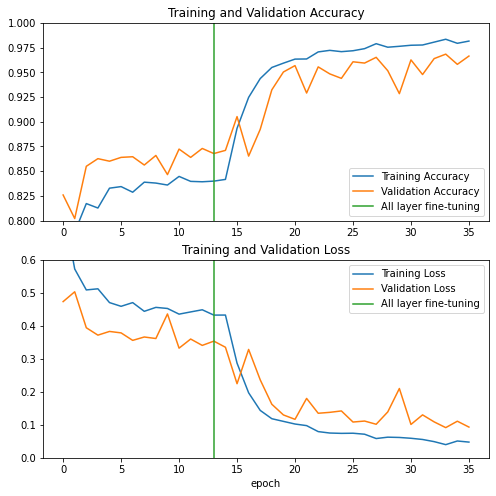

In [15]:
initial_epochs=history.epoch[-1]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='All layer fine-tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.6])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='All layer fine-tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
18,0.039958,0.983479,0.999534,0.983856,0.982686,0.091601,0.968407,0.996334,0.969658,0.968407,0.0001
20,0.047672,0.981628,0.999210,0.982133,0.980835,0.093239,0.966473,0.997134,0.967076,0.965828,0.0001
15,0.059258,0.977399,0.998522,0.978152,0.976342,0.101244,0.962605,0.996785,0.963824,0.961960,0.0001
12,0.058469,0.978985,0.998939,0.980262,0.978060,0.101803,0.965184,0.995463,0.965762,0.963894,0.0001
10,0.074595,0.971848,0.997925,0.972726,0.971055,0.108548,0.960671,0.996106,0.963660,0.957447,0.0001
17,0.049072,0.980571,0.999045,0.981606,0.980439,0.109026,0.963894,0.995703,0.965094,0.962605,0.0001
19,0.051009,0.979381,0.998889,0.980154,0.979117,0.111071,0.958092,0.995804,0.958092,0.958092,0.0001
11,0.071582,0.973962,0.998155,0.975603,0.972509,0.111543,0.959381,0.995426,0.961837,0.958736,0.0001
5,0.102514,0.963389,0.996614,0.964736,0.961803,0.116774,0.956802,0.995407,0.958576,0.954868,0.0001


In [17]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
eff_model.compile(
    optimizer=adam_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

history_finetune3 = eff_model.fit(train_generator,
                            epochs=45,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-05
Epoch 35/45
237/237 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9896 - AUC: 0.9995 - precision: 0.9899 - recall: 0.9894
Epoch 00035: val_loss improved from 0.09160 to 0.08924, saving model to ./weights/efficientnet_3channel_scratch.hdf5
End of epoch 34. Learning rate: 1e-05
237/237 [==============================] - 114s 451ms/step - loss: 0.0281 - accuracy: 0.9896 - AUC: 0.9995 - precision: 0.9899 - recall: 0.9894 - val_loss: 0.0892 - val_accuracy: 0.9678 - val_AUC: 0.9972 - val_precision: 0.9684 - val_recall: 0.9678 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 36/45
237/237 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9896 - AUC: 0.9998 - precision: 0.9898 - recall: 0.9896
Epoch 00036: val_loss improved from 0.08924 to 0.08723, saving model to ./weights/efficientnet_3channel_scratch.hdf5
End of epoch 35. Learning rate: 1e-05
237/237 [==============================] - 106s 445ms/step - loss

In [29]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6)
eff_model.compile(
    optimizer=adam_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

history_finetune4 = eff_model.fit(train_generator,
                            epochs=55,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune3.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  5e-06
Epoch 45/55
237/237 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9942 - AUC: 0.9998 - precision: 0.9943 - recall: 0.9942
Epoch 00045: val_loss did not improve from 0.08723
End of epoch 44. Learning rate: 5e-06
237/237 [==============================] - 115s 454ms/step - loss: 0.0156 - accuracy: 0.9942 - AUC: 0.9998 - precision: 0.9943 - recall: 0.9942 - val_loss: 0.1077 - val_accuracy: 0.9678 - val_AUC: 0.9945 - val_precision: 0.9684 - val_recall: 0.9678 - lr: 5.0000e-06
Learning rate:  5e-06
Epoch 46/55
237/237 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9944 - AUC: 0.9999 - precision: 0.9944 - recall: 0.9944
Epoch 00046: val_loss did not improve from 0.08723
End of epoch 45. Learning rate: 5e-06
237/237 [==============================] - 106s 446ms/step - loss: 0.0147 - accuracy: 0.9944 - AUC: 0.9999 - precision: 0.9944 - recall: 0.9944 - val_loss: 0.1073 - val_accuracy: 0.9671 - val_AUC: 

### Model Evaluation

In [30]:
model = tf.keras.models.load_model('./weights/efficientnet_3channel_scratch.hdf5')

#### Montgomery County Dataset Evaluation

In [31]:
TEST_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)


res = model.predict(test_generator)

Found 28 images belonging to 3 classes.


In [32]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,target_names=['normal','tb'],digits=4)
print(report)

              precision    recall  f1-score   support

      normal     0.7368    0.8750    0.8000        16
          tb     0.7778    0.5833    0.6667        12

    accuracy                         0.7500        28
   macro avg     0.7573    0.7292    0.7333        28
weighted avg     0.7544    0.7500    0.7429        28



#### Shenzhen Dataset Evaluation

In [33]:
TEST_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/test/Shenzhen'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = model.predict(test_generator)

Found 134 images belonging to 3 classes.


In [34]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,target_names=['normal','tb'],digits=4)
print(report)

              precision    recall  f1-score   support

      normal     0.6947    1.0000    0.8199        66
          tb     1.0000    0.5735    0.7290        68

    accuracy                         0.7836       134
   macro avg     0.8474    0.7868    0.7744       134
weighted avg     0.8496    0.7836    0.7737       134



#### TBX11 dataset

In [35]:
TEST_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/val'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)


res = model.predict(test_generator)

Found 1551 images belonging to 3 classes.


In [36]:
res = model.predict(test_generator)
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,target_names=['health','sick','tb'],digits=4)
print(report)

              precision    recall  f1-score   support

      health     0.9325    0.9843    0.9577       702
        sick     0.9817    0.9817    0.9817       600
          tb     0.9524    0.8032    0.8715       249

    accuracy                         0.9542      1551
   macro avg     0.9555    0.9231    0.9370      1551
weighted avg     0.9547    0.9542    0.9531      1551

